In [33]:
#region Imports
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import time
from sklearn.metrics import silhouette_samples,silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from os.path import expanduser as ospath
import itertools
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
#endregion
 
#region Preprocessing
'''
``````````````````
Seoul Bike Dataset
``````````````````
'''
bike = pd.read_csv('SeoulBikeData.csv', delimiter = ',',encoding='unicode_escape')
# The Date column was considered to be not so useful for the purposes of clustering
# Hence, only the month of the year was kept in the column to reflect the time of the year
# Other columns appear to be sufficient to explain the state of the day
# We are not trying to predict the changes in bike count but rather attempt to relate the type of day with bike rentals

# Change the 'Date' column to DateTime format
#bike['Date'] = pd.to_datetime(bike['Date'])
bike.drop(['Date'],axis=1,inplace=True)
# Keep only the Month information in the Date column
#bike['Date'] = bike.Date.dt.strftime('%m').astype(int)
print(bike)

# Describe to assess how the data looks in the data set
# Should note how the number ranges are different between columns
# e.g. Dew point temperature maximum is only 27.2 while Rented Bike Count maximum is 3556
print(bike.describe())

# Check the type of the columns to assess if any columns requiring change of data type
print(bike.info())

# We can see that there are no nulls in the dataset which is good.
# Create function to transform non interger features using LabelEncoder
def encode_features(dataframe):
    features = ['Seasons','Holiday','Functioning Day']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataframe[feature])
        dataframe[feature] = le.transform(dataframe[feature])
    
    return dataframe

# Use above function to encode each features for the dataframe 'bike'. Create new dataframe called 'bike_df'
bike_df = encode_features(bike)
bike_df.head()

# bike_df = bike_df.drop(['Date'],axis=1)
bike_df
 
#Standardizing the data because features arent the same scale
df_std = StandardScaler().fit_transform(bike_df)


      Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
0                   254     0             -5.2           37               2.2   
1                   204     1             -5.5           38               0.8   
2                   173     2             -6.0           39               1.0   
3                   107     3             -6.2           40               0.9   
4                    78     4             -6.0           36               2.3   
5                   100     5             -6.4           37               1.5   
6                   181     6             -6.6           35               1.3   
7                   460     7             -7.4           38               0.9   
8                   930     8             -7.6           37               1.1   
9                   490     9             -6.5           27               0.5   
10                  339    10             -3.5           24               1.2   
11                  360    1

[0.20784509 0.39868731 0.49535196 0.58044123 0.65689019 0.72879265
 0.79986553 0.85943384 0.91251245 0.95932443 0.98558031 0.99965228
 1.        ]


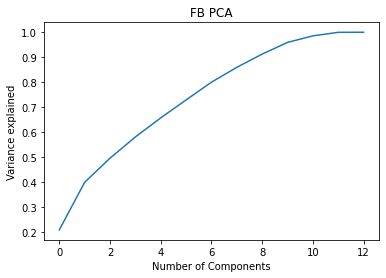

In [34]:

#endregion
 
#region Feature Selection (PCA)
def pca(dataframe):
    global pca
    pca=PCA().fit(dataframe)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance explained')
    plt.title('FB PCA')
    print(np.cumsum(pca.explained_variance_ratio_)) #Tells us explained varaicne for each number of principal components
    return (plt.show()) #Plot
pca(df_std) #Fits our data, which tells us 3 Principal components explains 74% variance
 
#Reducing Dimensionality to 3 principal components
pca2 = PCA(n_components=7)
pcadata = pca2.fit_transform(df_std) #Transforming standardized data to 3 Principal components


In [ ]:


''' 
KMeans 
'''

#Elbow Plot
clusters= range(1,15)
SSE=[]
for k in clusters:
        model = KMeans(n_clusters=k)
        model.fit(pcadata)
        SSE.append(model.inertia_)
        print(SSE)
plt.plot(range(1,15),SSE,marker='o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('SSE')
plt.title('Elbow Plot FB')
plt.tight_layout()
plt.show()
 
#Davis Bouldin Score
db = {}
for k in range(2,15):
    kmeans = KMeans(n_clusters=k).fit(pcadata)
    clusters = kmeans.labels_
    db[k] = davies_bouldin_score(pcadata,clusters)
    print("For n_clusters =", k, "The FB KMeans DBI is :", db[k])
 
plt.figure(figsize=(12,6))
plt.plot(list(db.keys()),list(db.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin scores")
plt.title("FB KMeans Davies-Bouldin Scores")
plt.show()
 
 
 
start = time.time()  # To start timer
k = range(2,15) #Testing outcome from K= 2:15
for n_clusters in k:
    fig, (ax1, ax2) = plt.subplots(1, 2) #Subplot with 1 row and 2 columns
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1]) #Range of silhouette coefficients
    ax1.set_ylim([0, len(pcadata) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters) #Clusterer with default parameters (worked the best)
    label = clusterer.fit_predict(pcadata)
    silhouette_avg = silhouette_score(pcadata, label) #Average silhouette score for each of the clusters
    print("For n_clusters =", n_clusters, "The KMeans CSM is :", silhouette_avg) #Silhouette score average for each sample
    sample_silhouette_values = silhouette_samples(pcadata, label)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[label == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i =ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([]) # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(label.astype(float) /n_clusters)
    ax2.scatter(pcadata[:, 0], pcadata[:, 1], marker='.', s=30, lw=0,alpha=0.7,c=colors, edgecolor='k')
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("Visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on FB data" "with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
end = time.time()  # To end the timer
print(f"Runtime of Kmeans is {end - start}")  # To print how long it took
plt.show()
 
#endregion
 

In [18]:

#region DBSCAN
 
#Detemining appropriate eps and
#To determine the appropriate eps and min_samples (which are vital parameters),
# I will put the dataset into the following code:
 
start = time.time()
pca_eps_values = np.arange(2,3,0.1)
pca_min_samples = np.arange(14,20)
pca_dbscan_params = list(itertools.product(pca_eps_values, pca_min_samples))
pca_no_of_clusters = []
sil_score = []
DB_score = []
epsvalues = []
min_samples = []
for p in pca_dbscan_params:
    pca_dbscan_cluster = DBSCAN(eps=p[0], min_samples=p[1]).fit(df2)
    epsvalues.append(p[0])
    min_samples.append(p[1])
    pca_no_of_clusters.append(len(np.unique(pca_dbscan_cluster.labels_)))
    sil_score.append(silhouette_score(df2, pca_dbscan_cluster.labels_))
    DB_score.append(davies_bouldin_score(df2, pca_dbscan_cluster.labels_))
pca_eps_min = list(zip(pca_no_of_clusters, sil_score, DB_score, epsvalues, min_samples))
pca_eps_min_df = pd.DataFrame(pca_eps_min, columns=['no_of_clusters', 'silhouette_score','DB_score', 'epsilon_values', 'minimum_points'])
pd.set_option('display.max_rows', None)
print(pca_eps_min_df)
 
end = time.time()
print(f"Runtime of the program is {end - start}")
 
#From this we can tell that the optimal number of eps is 1.9 and the optimal number min_samples is 7
#This also tells us that 2 clusters gives us a silhouette score of 0.8582 and DBI of 0.8867
 


    no_of_clusters  silhouette_score  DB_score  epsilon_values  minimum_points
0                5          0.393393  1.055104             2.0              14
1                5          0.393393  1.055104             2.0              15
2                5          0.393734  1.030953             2.0              16
3                5          0.393537  1.054855             2.0              17
4                5          0.393346  1.137577             2.0              18
5                5          0.393141  1.148616             2.0              19
6                5          0.393374  1.011598             2.1              14
7                5          0.393374  1.011598             2.1              15
8                5          0.393550  1.001913             2.1              16
9                5          0.393550  1.001913             2.1              17
10               5          0.393571  1.027977             2.1              18
11               5          0.393731  1.018736      

In [37]:
start = time.time()
## To find the best hyperparameters using silhouette coefficience method
#  Defining the list of hyperparameters to try
eps_list=np.arange(start=2, stop=10, step=0.1)
min_sample_list=np.arange(start=14, stop=20, step=1)
 
# Creating empty data frame to store the silhouette scores for each trials
silhouette_scores_data=pd.DataFrame()
 
for i in eps_list:
    for k in min_sample_list:

        # Generating DBSAN clusters
        db_bike = DBSCAN(eps=i, min_samples=k)

        if(len(np.unique(db_bike.fit_predict(df2)))>1):
            sil_score=silhouette_score(df2, db_bike.fit_predict(df2))
        else:
            continue
        trial_parameters="eps:" + str(i.round(1)) +" min_sample :" + str(k)

        silhouette_scores_data=silhouette_scores_data.append(pd.DataFrame(data=[[len(np.unique(pca_dbscan_cluster.labels_)),
        sil_score,trial_parameters]],
        columns=['cluster number','score', 'parameters']))
end = time.time()
print(f"Runtime of the program is {end - start}") 
# Finding out the best hyperparameters with highest Score
silhouette_scores_data.sort_values(by='score', ascending=False).head(1)



Runtime of the program is 2182.690481185913


cluster number     score              parameters
0               5  0.846368  eps:8.9 min_sample :19

For n_clusters = 2 The average silhouette_score is : 0.8463680341026469
For n_clusters = 2 The davies_bouldin score is : 0.10811895316455708
For n_clusters = 3 The average silhouette_score is : 0.8463680341026469
For n_clusters = 3 The davies_bouldin score is : 0.10811895316455708
For n_clusters = 4 The average silhouette_score is : 0.8463680341026469
For n_clusters = 4 The davies_bouldin score is : 0.10811895316455708
For n_clusters = 5 The average silhouette_score is : 0.8463680341026469
For n_clusters = 5 The davies_bouldin score is : 0.10811895316455708
For n_clusters = 6 The average silhouette_score is : 0.8463680341026469
For n_clusters = 6 The davies_bouldin score is : 0.10811895316455708
Runtime of the program is 22.51295304298401


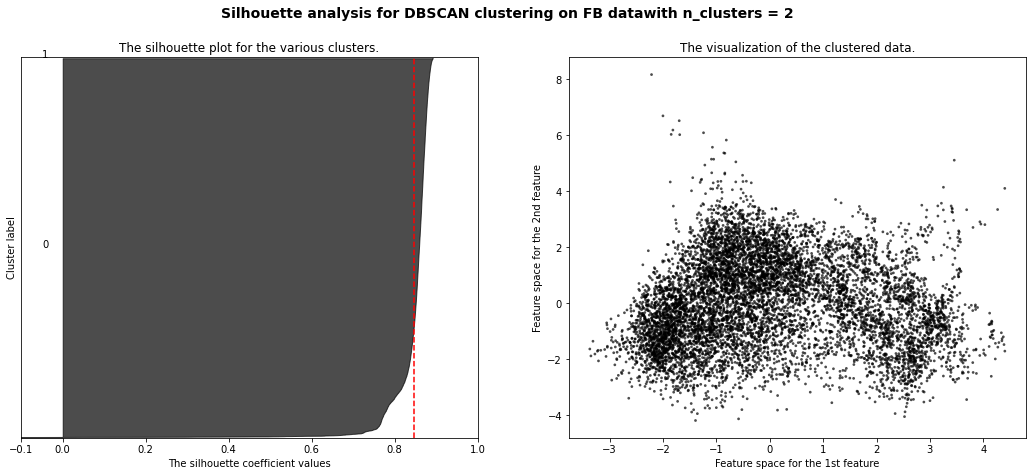

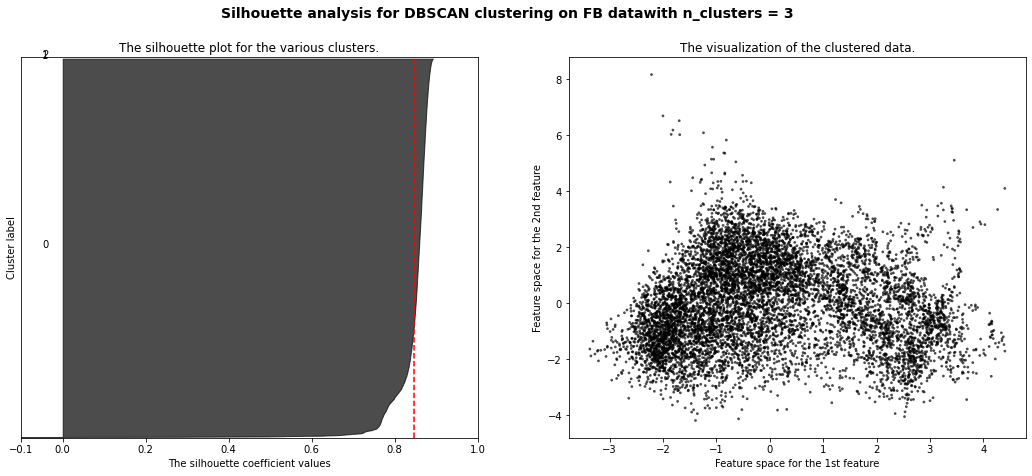

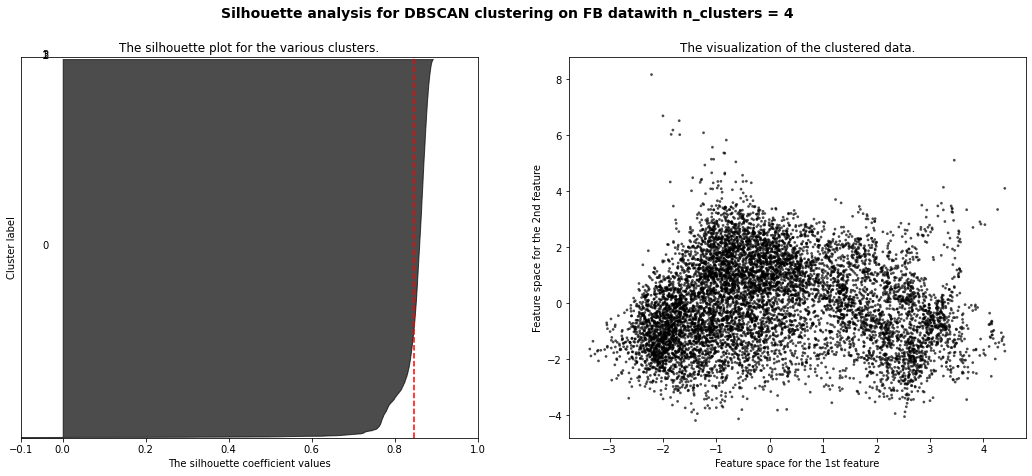

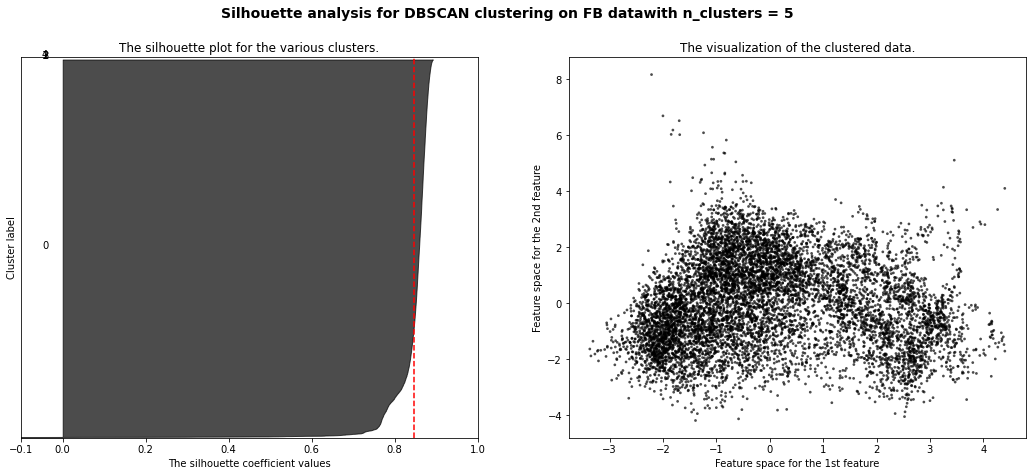

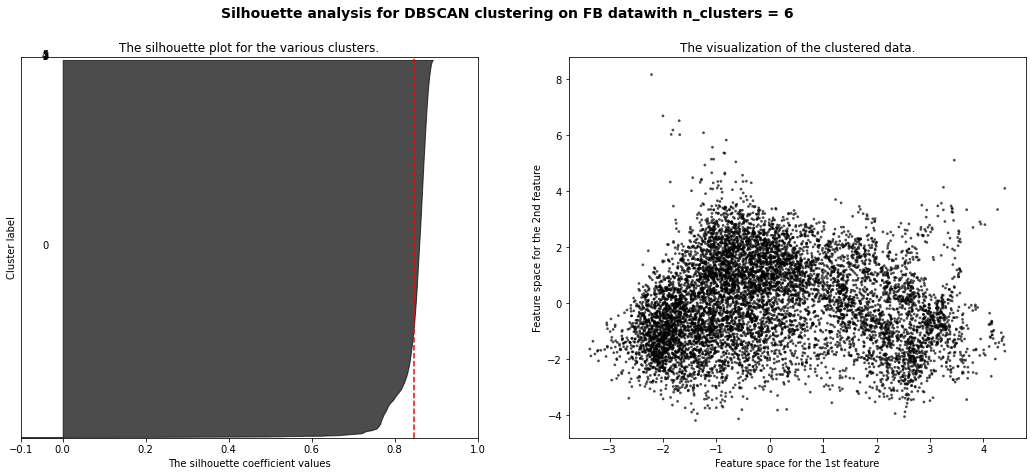

In [38]:
# 5/0.393/1.9/7
start = time.time()
range_n_clusters = range(2,7)
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(pcadata) + (n_clusters + 1) * 10])
 
 
    db = DBSCAN(eps=8.9, min_samples=19, metric='euclidean').fit(pcadata)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    cluster_labels = db.labels_
    silhouette_avg = silhouette_score(pcadata, cluster_labels)
    davies_bouldin = davies_bouldin_score(pcadata, cluster_labels)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
    print("For n_clusters =", n_clusters, "The davies_bouldin score is :", davies_bouldin)
    sample_silhouette_values = silhouette_samples(pcadata,cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i =ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([]) # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
 
    colors = cm.nipy_spectral(cluster_labels.astype(float) /n_clusters)
    ax2.scatter(pcadata[:, 0], pcadata[:, 1], marker='.', s=30, lw=0,alpha=0.7,c=colors, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for DBSCAN clustering on FB data" "with n_clusters = %d" % n_clusters),fontsize=14, fontweight='bold')
end = time.time()
print(f"Runtime of the program is {end - start}") 
# Finding out the best hyperparameters with highest Score
plt.show()
 
 
#endregion


For n_clusters = 2 The FB Agglomerative DBI is : 1.7567628721855066
For n_clusters = 3 The FB Agglomerative DBI is : 1.5677893570367463
For n_clusters = 4 The FB Agglomerative DBI is : 1.3538192026290756
For n_clusters = 5 The FB Agglomerative DBI is : 1.1250825035209713
For n_clusters = 6 The FB Agglomerative DBI is : 1.013711237458355
For n_clusters = 7 The FB Agglomerative DBI is : 1.0560439776155535
For n_clusters = 8 The FB Agglomerative DBI is : 0.9671576655189115
For n_clusters = 9 The FB Agglomerative DBI is : 1.0686915863076707
For n_clusters = 10 The FB Agglomerative DBI is : 1.104902310862579
For n_clusters = 11 The FB Agglomerative DBI is : 1.128358712077563


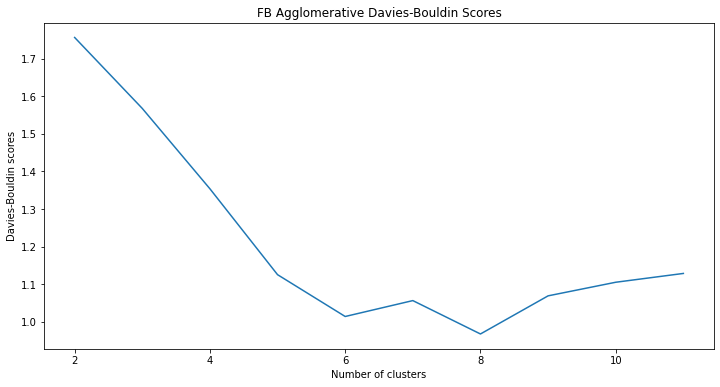

For n_clusters = 2 The Agglomerative CSM is : 0.2596709800889111
For n_clusters = 3 The Agglomerative CSM is : 0.23450221464004736
For n_clusters = 4 The Agglomerative CSM is : 0.26730659195531153
For n_clusters = 5 The Agglomerative CSM is : 0.2850578899312334
For n_clusters = 6 The Agglomerative CSM is : 0.29613161716701775
For n_clusters = 7 The Agglomerative CSM is : 0.2894798831588
For n_clusters = 8 The Agglomerative CSM is : 0.29435094341243295
For n_clusters = 9 The Agglomerative CSM is : 0.2731091065763216
For n_clusters = 10 The Agglomerative CSM is : 0.25106644421294916
For n_clusters = 11 The Agglomerative CSM is : 0.2439203217460226
Runtime of the agglomerative Clustering is 51.71538996696472


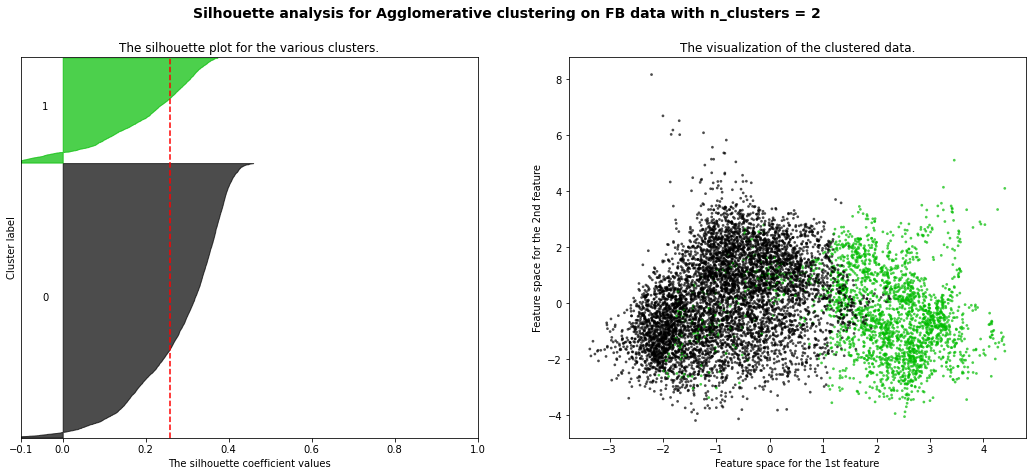

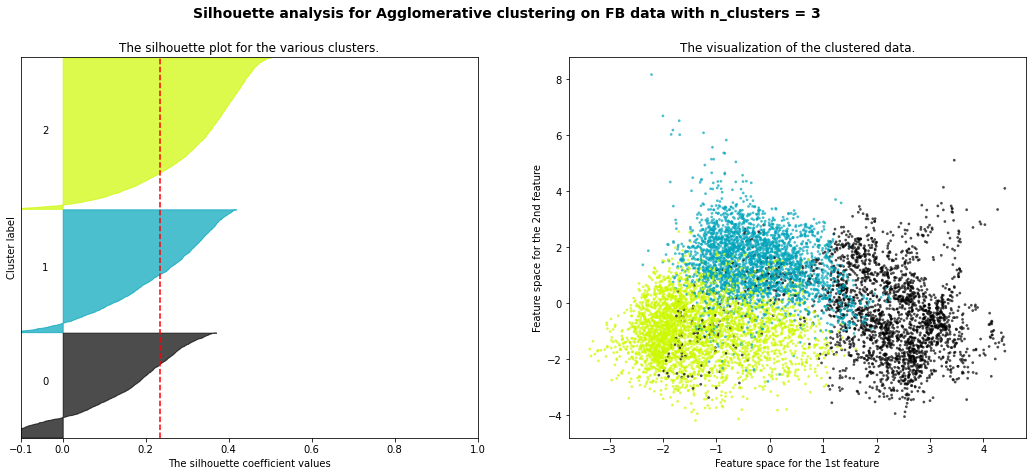

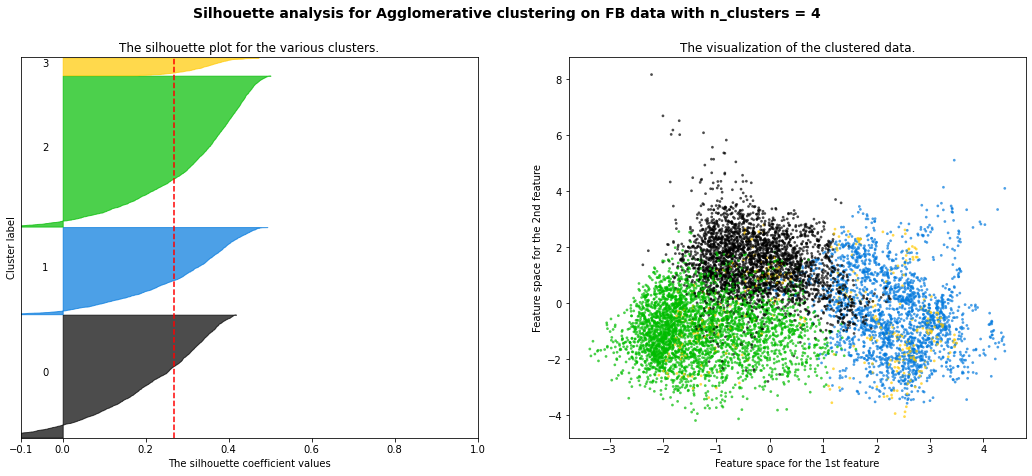

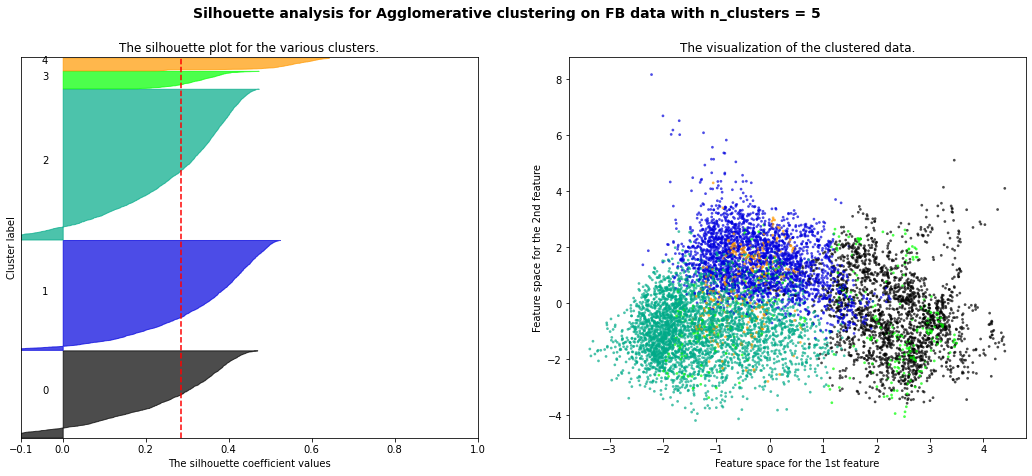

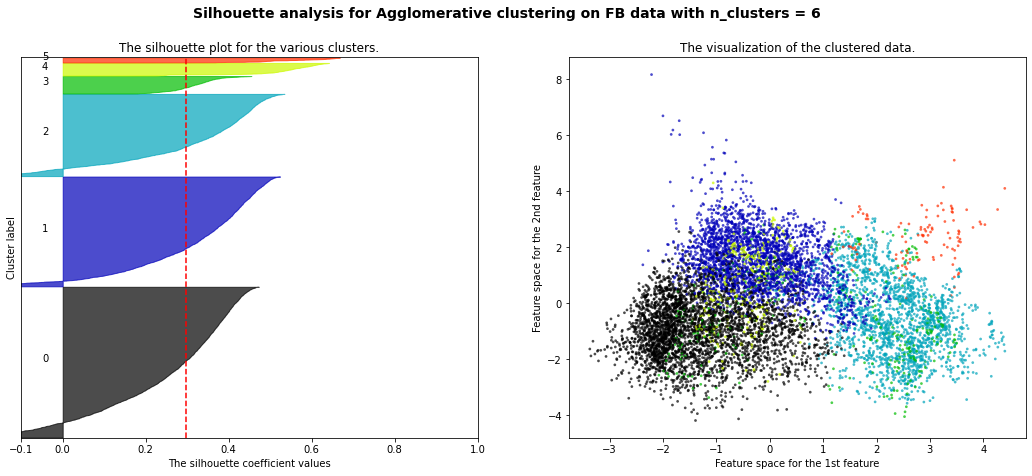

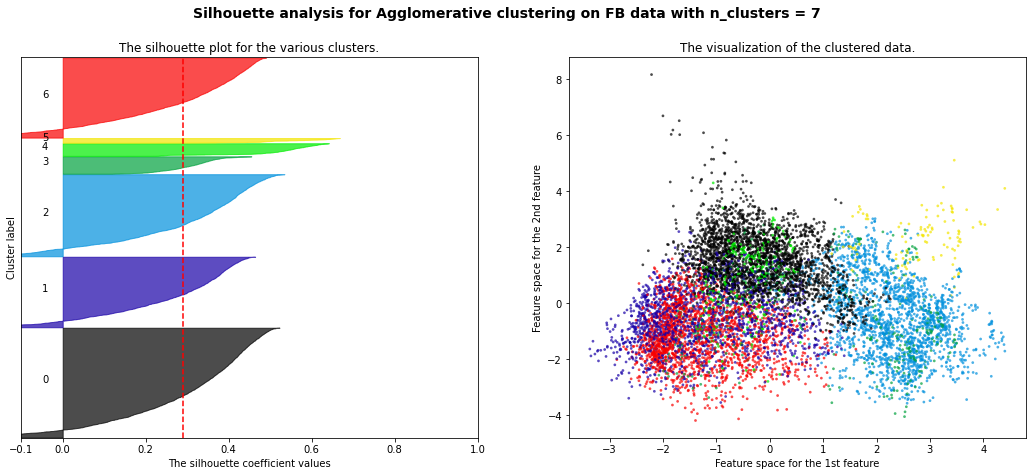

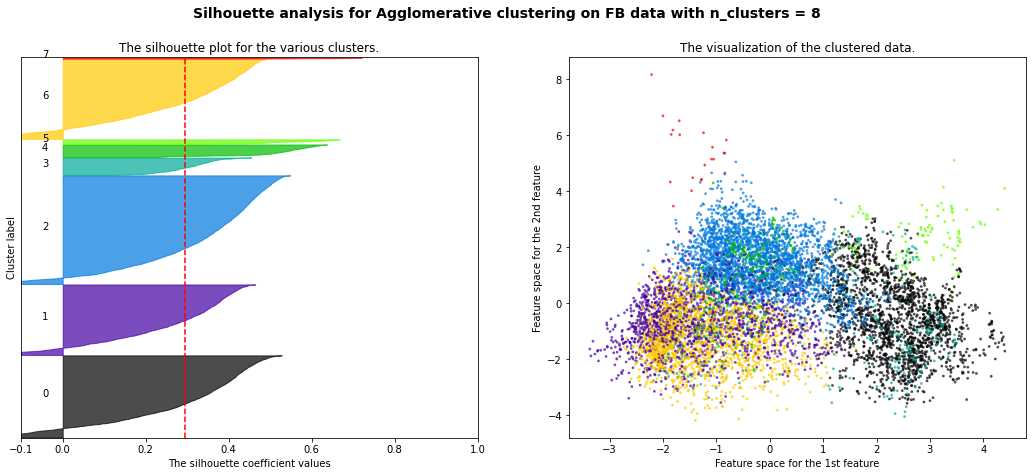

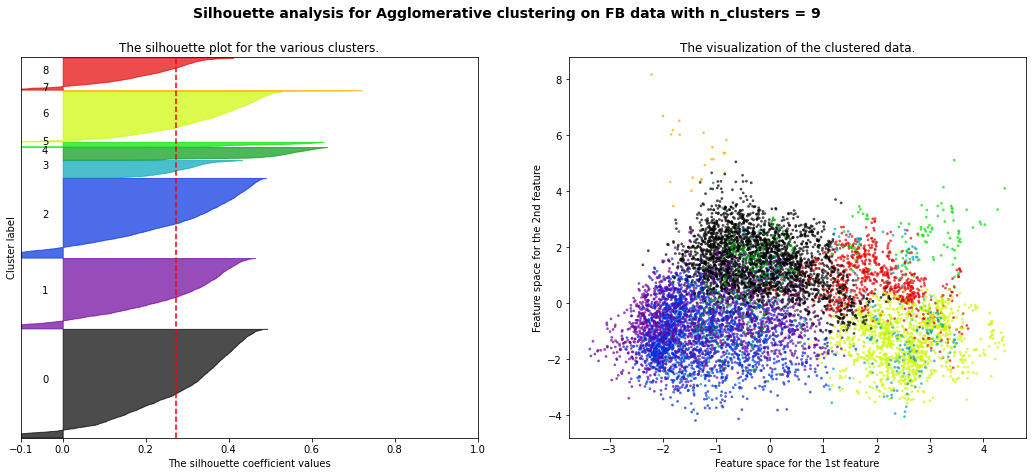

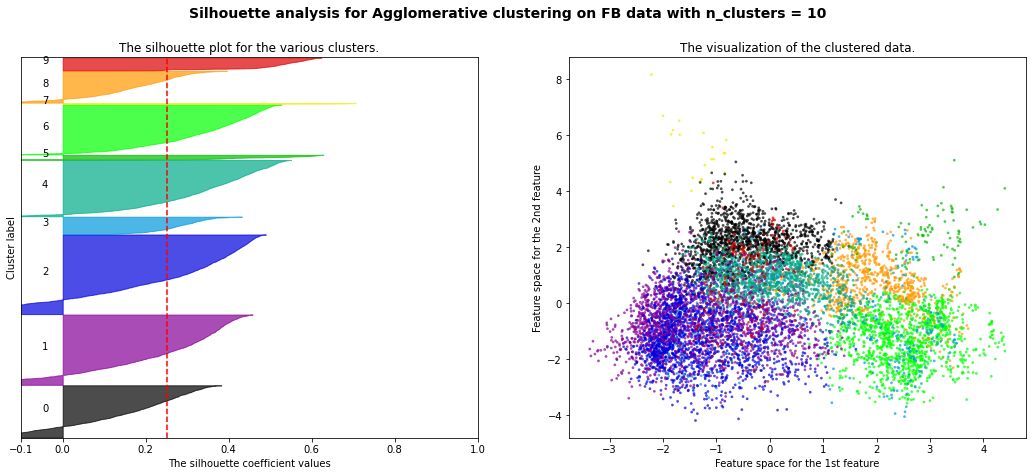

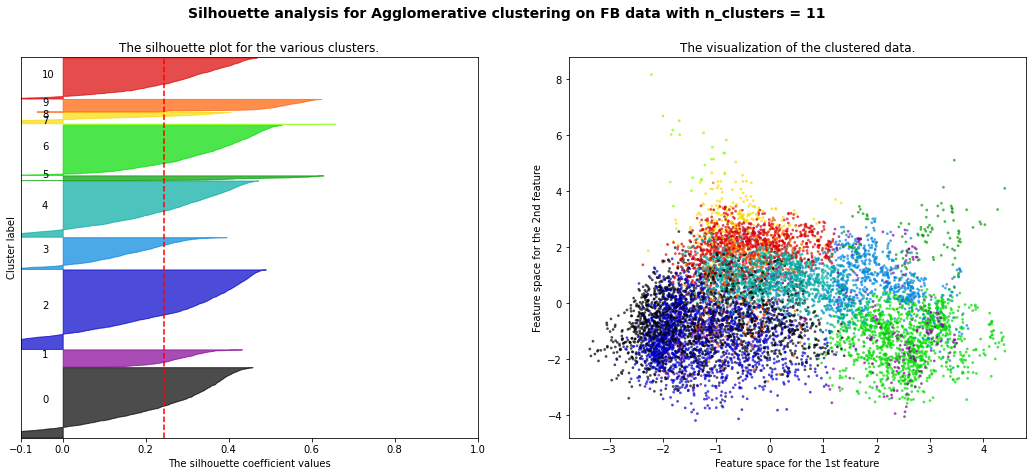

In [20]:

#region Agglomerative
 
#Davis Bouldin Score
db = {}
for k in range(2,12):
    agglomerative = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward').fit(pcadata)
    clusters = agglomerative.labels_
    db[k] = davies_bouldin_score(pcadata,clusters)
    print("For n_clusters =", k, "The FB Agglomerative DBI is :", db[k])
 
plt.figure(figsize=(12,6))
plt.plot(list(db.keys()),list(db.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin scores")
plt.title("FB Agglomerative Davies-Bouldin Scores")
plt.show()
 
start = time.time()
#Silhouette
range_n_clusters = range(2,12)
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(pcadata) + (n_clusters + 1) * 10])
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    cluster_labels = clusterer.fit_predict(pcadata) #Fitting the data to the model
    silhouette_avg = silhouette_score(pcadata, cluster_labels)
    print("For n_clusters =", n_clusters,"The Agglomerative CSM is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(pcadata,cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i =ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([]) # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
 
    colors = cm.nipy_spectral(cluster_labels.astype(float) /n_clusters)
    ax2.scatter(pcadata[:, 0], pcadata[:, 1], marker='.', s=30, lw=0,alpha=0.7,c=colors, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for Agglomerative clustering on FB data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
end = time.time()
print(f"Runtime of the agglomerative Clustering is {end - start}")
plt.show()
 
#endregion
